In [1]:
from pycocotools.coco import COCO
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import torch
from torchvision import transforms
import pickle
import cv2 as cv
from skimage.util import random_noise

mean = (.5, .5, .5)
std = (.5, .5, .5)
normalize = transforms.Normalize(mean, std)


def transform(inp, shape, normalize=False):
    
    if type(inp) == np.ndarray:
        inp_tensor = torch.from_numpy(inp)
        inp_tensor = inp_tensor.type(torch.FloatTensor)
    else:
        inp_tensor = torch.tensor(inp)
    
    inp_tensor = inp_tensor.view(shape)
    
    if normalize:
        inp_tensor = normalize(inp_tensor)
    
    return inp_tensor

class PresenceDataset(Dataset):
    
    augment_dict = {1: "rotate", 2: "shift"}

    def __init__(self, data_path, annotation_path, norm=normalize):

        super().__init__()
        self.coco = COCO(annotation_path)
        with open('./present_list.txt', 'rb') as fb:
            self.present_list = pickle.load(fb)
        with open('./non_present_list.txt', 'rb') as fb:
            self.non_present_list = pickle.load(fb)
        self.data_list = self.present_list + self.non_present_list
        self.cats = set(self.coco.getCatIds())
        self.data_path = data_path
        self.normalize = normalize
        # getting the list of IDs associated with present GT pair

    def __len__(self):

        return len(self.data_list)

    def __getitem__(self, idx):

        img_id = self.data_list[idx]
        ann_lst = self.coco.getAnnIds(img_id, iscrowd=False, areaRng=[10000, float('inf')])

        if ann_lst is []:
            return None

        else:

            present_set = set()
            for annot_id in ann_lst:
                cat = self.coco.loadAnns(annot_id)[0]['category_id']
                if cat not in present_set:
                    present_set.add(cat)
                else:
                    continue

            # getting the target depending on presence of GT pair
            if img_id in self.present_list:
                target, presence, _, _ = self._crop_random(present_set,
                                                           img_id, True, idx)
            else:
                non_present_lst = list(self.cats - present_set)
                target, presence, _, _ = self._crop_random(non_present_lst,
                                                           img_id, False, idx)

            img_meta = self.coco.loadImgs(img_id)[0]
            img = np.array(Image.open(''.join([self.data_path, '/',
                                               img_meta['file_name']])))

            img = self.__class__._rescale(img, (512, 512), self.normalize)
            target = self.__class__._rescale(target, (96, 96), self.normalize)

            if presence:
                out = transform([1,0], (1,2), False)
            else:
                out = transform([0,1], (1,2), False)

            return {"image_pair": (img, target), "presence": out}

    @staticmethod
    def _rescale(img, shape, normalize):

        img_obj = Image.fromarray(img)
        img_obj.thumbnail(size=shape)
        resized_img = Image.new('RGB', shape, 0)
        resized_img.paste(img_obj, ((shape[0] - img_obj.size[0])//2,
                                    (shape[1] - img_obj.size[1])//2))
        resized_img = np.array(resized_img)
        
        return transform(resized_img,
                         (3, shape[0], shape[1]),
                         normalize)

    def _crop_random(self, category_lst, img_id, is_present, idx):
        '''
        Crops the target image and returns both target array
        and presence boolean

        Args: category_list - used to get the random image where
                            certain category is present

              img_id - ID of the scene from pair, used if is_present
                       boolean is True to assure the cropped
                       target being from another image

              is_present - if True, will remove ID of the image
                           from possible candidate for target list

        Output: cropped - proposed target cropped image

                is_present - presence of target in the img_id
        '''

        if is_present:
            ann_ids = self.coco.getAnnIds(imgIds=img_id, areaRng=[64 ** 2, 96 ** 2], iscrowd=False)
            
        
        else: 
            ann_ids = self.coco.getAnnIds(catIds=category_lst,
                                          areaRng=[64**2, 96**2], iscrowd=False)
        
        annotation = self.coco.loadAnns(random.choice(ann_ids))[0]
        target_id = annotation['image_id']

        # bbox of target
        x, y, w, h = annotation['bbox']
        area = annotation['area']

        # cropping the target with specified bounding box
        meta = self.coco.loadImgs(target_id)[0]
        arr_img = np.array(Image.open(''.join([self.data_path, '/',
                                               meta['file_name']])))
        cropped = arr_img[int(y):int(y+h), int(x):int(x+w)]
        
        if is_present:
            augment_id = random.randint(1,2)
            augment = self.augment_dict[augment_id]
            if augment == "rotate":
                cropped = cv.rotate(cropped, cv.ROTATE_90_CLOCKWISE)
            elif augment == "shift":
                cropped = arr_img[int(y)+20:int(y+h)+20, int(x):int(x+w)+20]
            
            # adding salt and pepper noize
            cropped = random_noise(cropped)
                

        return cropped, is_present, area, annotation['category_id']


In [2]:
dataDir='/media/cimr/DATA_2/few-shot-object-detection/datasets/coco'
TRAIN_IMAGES_DIRECTORY = '/media/cimr/DATA_2/few-shot-object-detection/datasets/coco/train2017/'
TRAIN_ANNOTATIONS_PATH = '{}/annotations/instances_train2017.json'.format(dataDir)

data = PresenceDataset(TRAIN_IMAGES_DIRECTORY, TRAIN_ANNOTATIONS_PATH)

# idx = random.choice(list(range(data.__len__())))
# sample_dict = data.__getitem__(idx)
# scene, target = sample_dict['image_pair']
# presence = sample_dict['presence']
# print("Presence: {}, Image shape {}".format(presence.shape, scene.shape))

# data_loader = DataLoader(data, batch_size=1, num_workers=4, shuffle=False)
# # problem_ids = []
# for idx, sample in enumerate(data_loader):
#     if sample is not None:
#         scene, target = sample["image_pair"]
#         presence = sample["presence"]
#         if idx % 5000 == 0:
#             print("Scene shape batch {}, target shape batch {}, presence shape batch {}".format(scene.shape, target.shape, presence.shape))
#             print("Index {}".format(idx))
#     else:
#         print("Annotations is empty for the image")
# except_imgs = []
# for i in range(data.__len__()):
#     try:
#         sample = data.__getitem__(i)
#     except:
#         except_imgs.append(data.data_list[i])
#         print("Image which doesn't have suited annotation")

loading annotations into memory...
Done (t=12.64s)
creating index...
index created!


True


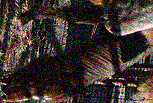

In [22]:
import time
idx = random.choice(range(data.__len__()))
sample = data.__getitem__(idx)
image, target = sample['image_pair']
presence = sample['presence']
Image.fromarray(image).show()
print(presence)
if presence:
    target = (target * 255).astype(np.uint8)
Image.fromarray(target)


In [6]:
type(target)

numpy.ndarray

In [ ]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

In [ ]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

In [ ]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [ ]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [ ]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [ ]:
# initialize COCO api for person keypoints annotations
annFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)
coco_kps=COCO(annFile)

In [ ]:
# load and display keypoints annotations
plt.imshow(I); plt.axis('off')
ax = plt.gca()
annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_kps.loadAnns(annIds)
coco_kps.showAnns(anns)

In [ ]:
# initialize COCO api for caption annotations
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

In [ ]:
# load and display caption annotations
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.imshow(I); plt.axis('off'); plt.show()